In [8]:
#Thanks to Sendtex, Martin Benning, Nam Nguyen. 

import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import *

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [10]:
#Image transformation and Data Augmentation
transform_train= transforms.Compose([transforms.Resize((150,150)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#random hori flip is one kind of data augmentation, flip some random images horizontally 

transform_test= transforms.Compose([transforms.Resize((150,150)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#no need data augmentation for the testing data

In [11]:
#load images from the directories
train= datasets.ImageFolder(r'C:\Users\neera\intel-image-classification\seg_train\seg_train', transform= transform_train)
test= datasets.ImageFolder(r'C:\Users\neera\intel-image-classification\seg_test\seg_test', transform= transform_test)

In [12]:
#running data iterators
batch_size=128
epochs= 10
train_loader= DataLoader(train,batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test,batch_size=batch_size, shuffle=True)

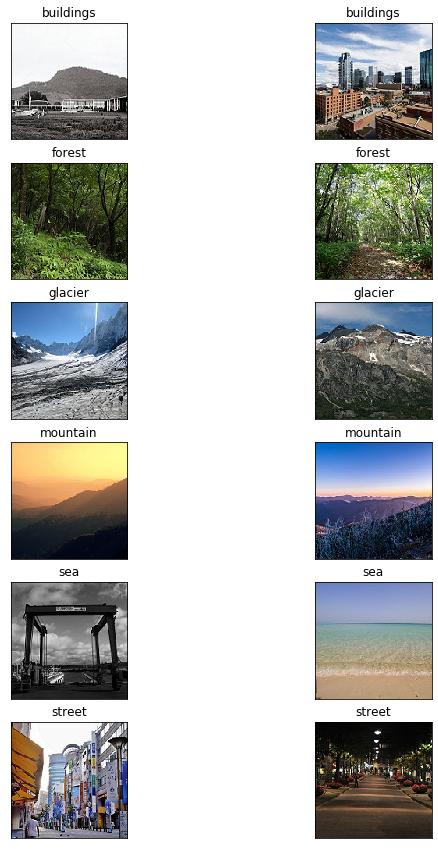

In [14]:
#DATA EXPLORATION - what are we looking at?
import os
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
folders = os.listdir(r'C:\Users\neera\intel-image-classification\seg_train\seg_train')

images = []
labels = []
for cl in folders:
    path = os.path.join(r'C:\Users\neera\intel-image-classification\seg_train\seg_train', cl, '*.jpg')
    for file in glob(path)[:2]:
        with Image.open(file) as f:
            images.append(np.array(f))
            labels.append(cl)
            
fig = plt.figure(figsize=(10, 15))

for i, image in enumerate(images):
    ax = fig.add_subplot(6, 2, i+1)
    ax.imshow(image)
    ax.set_title(labels[i])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()#initialises the inherited methods from the parent class
        #fc stands for fully connected
        #the first layer is the input and the last layer is the output
        self.fc1 = nn.Linear(150*150*3, 64) #create a self connected fully connected neural network (linear). 150*150 is
        self.fc2 = nn.Linear(64, 64) #the size of the flattened image. 256 is the output. Can be anything we want
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 6)
        
    
    #to pass the parameters to feed them through the neural network with activation function to normalise and keep it all between 
    #1 and 0. We use Relu here to prevent the numbers getting to ridiculously strange values (prevent loss explosion)
    #we have 6 options and we want only one to be selected. The rest need to be off. Or for example we want a distribution
    #where each output will have a probability on the output. For this we use logs of softmax function
    
    # we can put logic into here but this is all imagery
    def forward(self, x):
        x = F.relu(self.fc1(x)) # relu will keep output from these neural network layers exploding.
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) # no need to conduct relu on the output layer of course
        return F.log_softmax(x, dim=1) # dim 1 we want the output layer to be added to 1. 
                                       # distributes the this will compute the loss between 
neeraj = Net().to(device)
print(neeraj)

Net(
  (fc1): Linear(in_features=67500, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=6, bias=True)
)


In [16]:
def training_n(model):
    optimm= optim.Adam(model.parameters(), lr=0.00001)
    model.train()
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(tqdm(train_loader)):
            #let variables run on GPU
            x,y=x.to(device), y.to(device)
            # Run the forward pass
            output = model(x.view(-1,150*150*3))
            #print(yhat)
            #print(yhat.shape)
            #print(y.shape)
            loss = F.nll_loss(output, y) 
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimm.zero_grad()
            loss.backward()
            optimm.step()

            # Track the accuracy
            total = y.size(0)
            predicted= torch.argmax(output, axis=1)
            correct = (predicted == y).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 55 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
                
training_n(neeraj)

Epoch [1/10], Step [55/110], Loss: 1.5025, Accuracy: 42.97%
Epoch [1/10], Step [110/110], Loss: 1.3276, Accuracy: 51.22%



Epoch [2/10], Step [55/110], Loss: 1.3911, Accuracy: 46.88%
Epoch [2/10], Step [110/110], Loss: 1.3989, Accuracy: 43.90%



Epoch [3/10], Step [55/110], Loss: 1.2114, Accuracy: 62.50%
Epoch [3/10], Step [110/110], Loss: 1.2248, Accuracy: 57.32%



Epoch [4/10], Step [55/110], Loss: 1.1155, Accuracy: 61.72%
Epoch [4/10], Step [110/110], Loss: 1.1574, Accuracy: 60.98%



Epoch [5/10], Step [55/110], Loss: 1.1170, Accuracy: 60.16%
Epoch [5/10], Step [110/110], Loss: 1.1914, Accuracy: 60.98%



Epoch [6/10], Step [55/110], Loss: 1.1461, Accuracy: 53.12%
Epoch [6/10], Step [110/110], Loss: 1.0878, Accuracy: 54.88%



Epoch [7/10], Step [55/110], Loss: 1.1536, Accuracy: 54.69%
Epoch [7/10], Step [110/110], Loss: 1.2735, Accuracy: 46.34%



Epoch [8/10], Step [55/110], Loss: 1.2673, Accuracy: 51.56%
Epoch [8/10], Step [110/110], Loss: 1.2027, Accuracy: 52.44%



Epoch [9/10], Step [55/110], Loss: 1.2245, Accuracy: 49.22%
Epoch [9/10], Step [110/110], Loss: 1.1082, Accuracy: 54.88%



Epoch [10/10], Step [55/110], Loss: 0.9205, Accuracy: 67.19%
Epoch [10/10], Step [110/110], Loss: 0.9771, Accuracy: 64.63%



In [17]:
def test_n(model):
    model.eval()
    correct = 0
    accuracies=[]
    with torch.no_grad():
        for x, y in tqdm(test_loader):
            correct_b=0
            x, y = x.to(device), y.to(device)
            yhat = model(x.view(-1,150*150*3))
            prediction = yhat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += prediction.eq(y.view_as(prediction)).sum().item()
            correct_b= prediction.eq(y.view_as(prediction)).sum().item()
            accuracy=correct_b/batch_size
            accuracies.append(accuracy)
            

    print('Test set: Accuracy: {:.2f}%'.format(correct/len(test_loader.dataset)*100))
    
test_n(neeraj)


Test set: Accuracy: 56.27%
